## Original code: [Theo Wolf](https://medium.com/@theo.wolf/physics-informed-neural-networks-a-simple-tutorial-with-pytorch-f28a890b874a)

### network.py

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)


class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out

    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()


class NetDiscovery(Net):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        self.r = nn.Parameter(data=torch.tensor([0.]))

### diff_equations.py

In [ ]:
import torch
import numpy as np


def grad(outputs, inputs):
    """Computes the partial derivative of
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )


def heating_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time) ##T0>Tenv
    return T

### code

Text(0.5, 0, 'Time (s)')

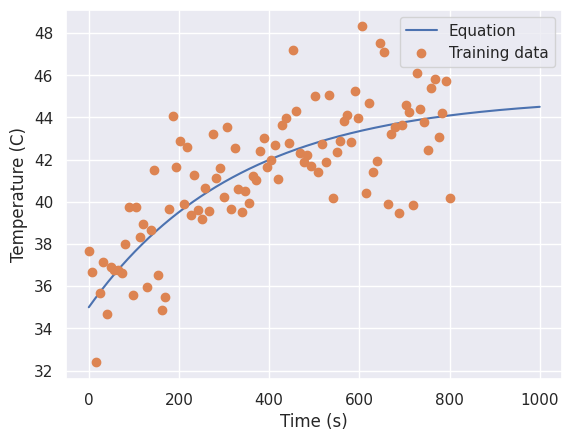

In [ ]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

# from network import Net, NetDiscovery
# from diff_equations import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

np.random.seed(10)

Tenv = 45 ###Land surface temperature
T0 = 35 ###Air temperature
R = .003
times = np.linspace(0, 1000, 1000)
eq = functools.partial(heating_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 800, 100)
T = eq(t) +  2 * np.random.randn(100)

# import pandas as pd
# data=pd.read_csv('G:/temperature_data.csv')
# t=data['time']
# T=data['temperature']

# import random

# # creating tensor from targets_df
# t_tensor = torch.tensor(data['time'].values)

# # printing out result
# print(t_tensor)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

Epoch 0/20000, loss: 2071.22
Epoch 2000/20000, loss: 337.22
Epoch 4000/20000, loss: 224.16
Epoch 6000/20000, loss: 33.81
Epoch 8000/20000, loss: 6.18
Epoch 10000/20000, loss: 5.29
Epoch 12000/20000, loss: 4.62
Epoch 14000/20000, loss: 4.26
Epoch 16000/20000, loss: 4.09
Epoch 18000/20000, loss: 3.94


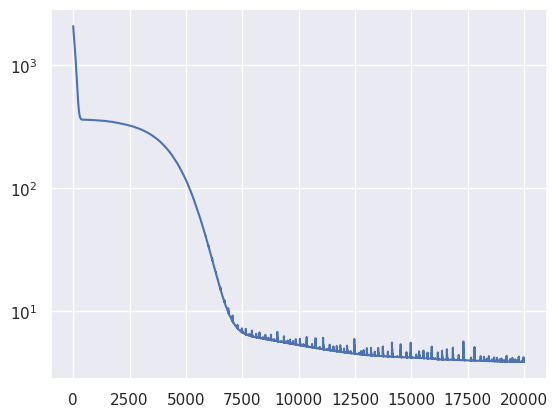

In [ ]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

In [ ]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

Epoch 0/20000, loss: 8469.03
Epoch 2000/20000, loss: 3691.14
Epoch 4000/20000, loss: 2218.57
Epoch 6000/20000, loss: 1398.91
Epoch 8000/20000, loss: 997.86
Epoch 10000/20000, loss: 826.87
Epoch 12000/20000, loss: 751.58
Epoch 14000/20000, loss: 696.36
Epoch 16000/20000, loss: 649.78
Epoch 18000/20000, loss: 608.05


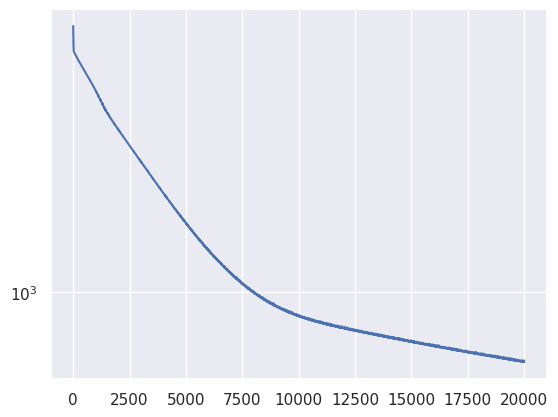

In [ ]:
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

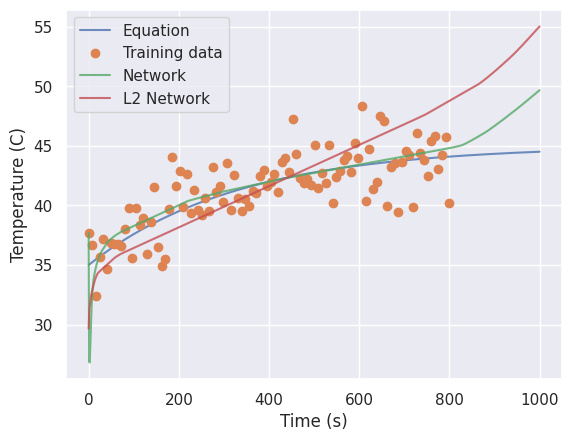

In [ ]:
predsreg = netreg.predict(times)

preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

Epoch 0/30000, loss: 2233.27
Epoch 3000/30000, loss: 320.65
Epoch 6000/30000, loss: 66.44
Epoch 9000/30000, loss: 6.35
Epoch 12000/30000, loss: 5.43
Epoch 15000/30000, loss: 5.05
Epoch 18000/30000, loss: 4.85
Epoch 21000/30000, loss: 4.70
Epoch 24000/30000, loss: 4.63
Epoch 27000/30000, loss: 4.59


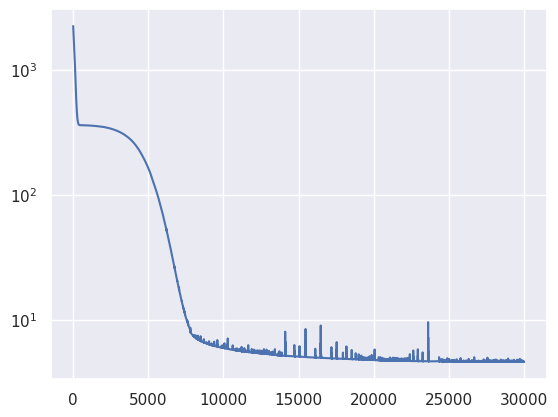

In [ ]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT

    return torch.mean(pde**2)

net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

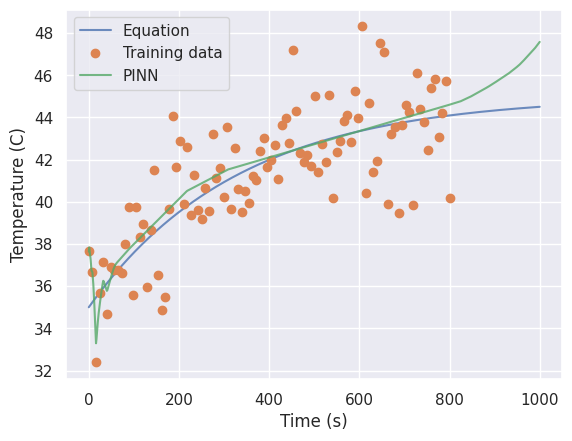

In [ ]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

Epoch 0/40000, loss: 2304.55
Epoch 4000/40000, loss: 345.10
Epoch 8000/40000, loss: 222.80
Epoch 12000/40000, loss: 8.87
Epoch 16000/40000, loss: 5.35
Epoch 20000/40000, loss: 5.02
Epoch 24000/40000, loss: 4.74
Epoch 28000/40000, loss: 4.61
Epoch 32000/40000, loss: 4.59
Epoch 36000/40000, loss: 4.58


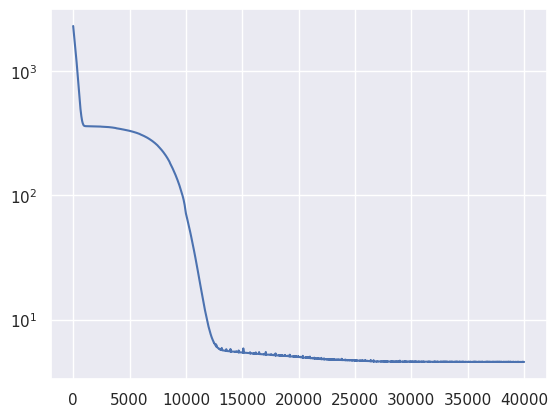

In [ ]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT

    return torch.mean(pde**2)
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Parameter containing:
tensor([0.0016], requires_grad=True)


Text(0.5, 0, 'Time (s)')

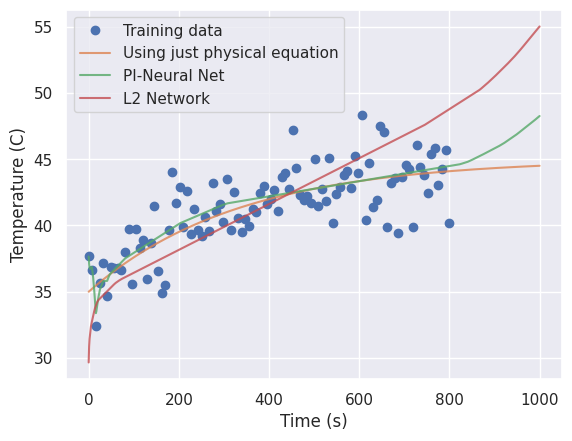

In [ ]:
preds = netdisc.predict(times)
print(netdisc.r)

plt.plot(t, T, 'o')
plt.plot(times, temps, alpha=0.8)
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)
plt.legend(labels=['Training data','Using just physical equation', 'PI-Neural Net', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')